In [12]:
import PISM
import os
import numpy as np
from PISM.testing import *

import numpy as np
import pylab as plt

config = PISM.Context().config

# reduce the grid size to speed this up
config.set_number("grid.Mx", 3)
config.set_number("grid.My", 5)
config.set_number("grid.Mz", 5)

seconds_per_year = 365 * 86400
# ensure that this is the correct year length
config.set_string("time.calendar", "365_day")
config.set_flag("ocean.th.clip_salinity", False)

# silence models' initialization messages
PISM.Context().log.set_threshold(1)

ice_density = config.get_number("constants.ice.density")
sea_water_density = config.get_number("constants.sea_water.density")

In [1]:
def melting_point_temperature(ice_thickness, salinity):
        a = [-0.0575, 0.0901, -7.61e-4]
        return a[0] * salinity + a[1] + a[2] * ice_thickness

In [14]:
h = np.arange(800, 1000, 100)
t = np.arange(4, 6, 1)
H, T = np.meshgrid(h, t)
nx, ny = T.shape

M = np.zeros_like(H)

gamma_T = 1.00e-4
gamma_S = 5.05e-7


for ice_thickness in h:
    for temperature in t:
        depth = ice_density / sea_water_density * ice_thickness
        salinity = 35.0
        melange_back_pressure = 0.0
        potential_temperature = temperature - melting_point_temperature(ice_thickness, salinity) + 273.13

        grid = shallow_grid()
        geometry = PISM.Geometry(grid)

        geometry.ice_thickness.set(depth)

        filename = "ocean_given_th_input.nc"

        PISM.util.prepare_output(filename)

        Th = PISM.IceModelVec2S(grid, "theta_ocean", PISM.WITHOUT_GHOSTS)
        Th.set_attrs("climate", "potential temperature", "Kelvin", "Kelvin", "", 0)
        Th.set(potential_temperature)
        Th.write(filename)

        S = PISM.IceModelVec2S(grid, "salinity_ocean", PISM.WITHOUT_GHOSTS)
        S.set_attrs("climate", "ocean salinity", "g/kg", "g/kg", "", 0)
        S.set(salinity)
        S.write(filename)

        config.set_string("ocean.th.file", filename)
        config.set_number("ocean.th.gamma_T", gamma_T)
        config.set_number("ocean.th.gamma_S", gamma_S)

        model = PISM.OceanGivenTH(grid)
        model.init(geometry)
        model.update(geometry, 0, 1)
        m = model.shelf_base_mass_flux().numpy()[0, 0]
        m = m * seconds_per_year / ice_density
        print(f"H={ice_thickness} m, TH={potential_temperature-273.13:.2f} C, S={salinity} g/kg, m={m:.2f} m/yr")


H=800 m, TH=6.53 C, S=35.0 g/kg, m=270.24 m/yr
H=800 m, TH=7.53 C, S=35.0 g/kg, m=307.72 m/yr
H=900 m, TH=6.61 C, S=35.0 g/kg, m=275.78 m/yr
H=900 m, TH=7.61 C, S=35.0 g/kg, m=313.30 m/yr


In [15]:
        gamma_T = 1.3e-4
        gamma_S = 5.05e-7

        ice_thickness = 650
        depth = ice_density / sea_water_density * ice_thickness
        salinity = 34.0
        melange_back_pressure = 0.0
        potential_temperature = 4.2 + 273.13
        # temperature = 1.7
        # potential_temperature = temperature - melting_point_temperature(ice_thickness, salinity) + 273.13

        grid = shallow_grid()
        geometry = PISM.Geometry(grid)

        geometry.ice_thickness.set(depth)

        filename = "ocean_given_th_input.nc"

        PISM.util.prepare_output(filename)

        Th = PISM.IceModelVec2S(grid, "theta_ocean", PISM.WITHOUT_GHOSTS)
        Th.set_attrs("climate", "potential temperature", "Kelvin", "Kelvin", "", 0)
        Th.set(potential_temperature)
        Th.write(filename)

        S = PISM.IceModelVec2S(grid, "salinity_ocean", PISM.WITHOUT_GHOSTS)
        S.set_attrs("climate", "ocean salinity", "g/kg", "g/kg", "", 0)
        S.set(salinity)
        S.write(filename)

        config.set_string("ocean.th.file", filename)
        config.set_number("ocean.th.gamma_T", gamma_T)
        config.set_number("ocean.th.gamma_S", gamma_S)


        model = PISM.OceanGivenTH(grid)
        model.init(geometry)
        model.update(geometry, 0, 1)
        m = model.shelf_base_mass_flux().numpy()[0, 0]
        m = m * seconds_per_year / ice_density
        print(f"H={ice_thickness} m, TH={potential_temperature-273.13:.2f} C, S={salinity} g/kg, m={m:.2f} m/yr")



H=650 m, TH=4.20 C, S=34.0 g/kg, m=231.47 m/yr


In [16]:
35900 / 362.5

99.03448275862068

In [1]:
import pandas as pd

In [67]:
db = pd.read_csv("/Users/andy/Downloads/Default Dataset.csv", names=["time", "temperature"])
mo = pd.read_csv("/Users/andy/Downloads/Default Dataset-2.csv", names=["time", "temperature"])
#theta_db = db.temperature - melting_point_temperature(250, 34)
#theta_mo = mo.temperature - melting_point_temperature(250, 34)
theta_db = db.temperature 
theta_mo = mo.temperature 

X_db = db.time.values.reshape(-1,1)
X_mo = mo.time.values.reshape(-1,1)
y_db = db.temperature.values
y_mo = mo.temperature.values
X_all = all.time.values.reshape(-1, 1)
y_all = all.temperature.values

In [59]:
all = pd.concat([db, mo])

In [64]:
all = all.sort_values(by="time")

Text(0, 0.5, 'Temperature (Celsius)')

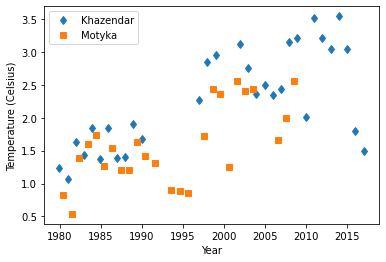

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(db.time, theta_db, "d", label="Khazendar")
ax.plot(mo.time, theta_mo, "s", label="Motyka")
ax.legend()
ax.set_xlabel("Year")
ax.set_ylabel("Temperature (Celsius)")

In [73]:
fig.savefig("disko-bay-temp.pdf")

In [4]:
import pymc3 as pm
import theano.tensor as tt
import numpy as np

In [ ]:
X_new = np.linspace(1980, 2018, 12*38 + 1)[:, None]

In [116]:
# Khazendar data
with pm.Model() as gp_db:
    ρ_db = pm.Gamma('ρ', 3, 2)
    η_db = pm.Gamma('η', 3, 2)
    K_db = pm.gp.cov.Matern32(1, ρ_db)
    σ_db = pm.Normal('σ', 0.2)
    gp_db = pm.gp.Marginal(cov_func=K_db)
    y_db_ = gp_db.marginal_likelihood("y", X=X_db, y=y_db, noise=σ_db)
    mp_db = pm.find_MAP()
    f_pred_db = gp_db.conditional("f_pred", X_new)
    pred_samples_db = pm.sample_posterior_predictive([mp_db], vars=[f_pred_db], samples=2000)

In [117]:
# Motyka data
with pm.Model() as gp_mo:
    ρ_mo = pm.Gamma('ρ', 3, 2)
    η_mo = pm.Gamma('η', 3, 2)
    K_mo = η_mo * pm.gp.cov.Matern32(1, ρ_mo)
    σ_mo = pm.Normal('σ', 0.2)
    gp_mo = pm.gp.Marginal(cov_func=K_mo)
    y_mo_ = gp_mo.marginal_likelihood("y", X=X_mo, y=y_mo, noise=σ_mo)
    mp_mo = pm.find_MAP()
    f_pred_mo = gp_mo.conditional("f_pred", X_new)
    pred_samples_mo = pm.sample_posterior_predictive([mp_mo], vars=[f_pred_mo], samples=2000)

In [120]:
# Khazendar and Motyka merged
with pm.Model() as gp_all:
    ρ_all = pm.Gamma('ρ', 3, 2)
    η_all = pm.Gamma('η', 3, 2)
    K_all = η_all * pm.gp.cov.Matern32(1, ρ_all)
    σ_all = pm.Normal('σ', 0.2)
    gp_all = pm.gp.Marginal(cov_func=K_all)
    y_all_ = gp_all.marginal_likelihood("y", X=X_all, y=y_all, noise=σ_all)
    mp_all = pm.find_MAP()
    f_pred_all = gp_all.conditional("f_pred", X_new)
    pred_samples_all = pm.sample_posterior_predictive([mp_all], vars=[f_pred_all], samples=20)

(0.0, 5.0)

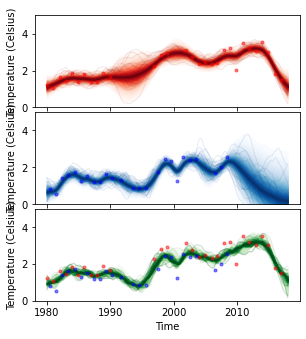

In [121]:
fig, ax = plt.subplots(3, 1, sharex="col", sharey="row", figsize=[4.75, 5.25])
fig.subplots_adjust(hspace=0.05, wspace=0.30)


# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax[0], pred_samples_db["f_pred"], X_new, palette="Reds");
plot_gp_dist(ax[1], pred_samples_mo["f_pred"], X_new, palette="Blues");
plot_gp_dist(ax[2], pred_samples_all["f_pred"], X_new, palette="Greens");

# plot the data and the true latent function
# plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax[0].plot(X_db, y_db, 'or', ms=3, alpha=0.5, label="Observed data Khazendar");
ax[1].plot(X_mo, y_mo, 'ob', ms=3, alpha=0.5, label="Observed data Motyka");
ax[2].plot(X_db, y_db, 'or', ms=3, alpha=0.5, label="Observed data Khazendar");
ax[2].plot(X_mo, y_mo, 'ob', ms=3, alpha=0.5, label="Observed data Motyka");


# axis labels and title
ax[2].set_xlabel("Time")
ax[0].set_ylabel("Temperature (Celsius)")
ax[1].set_ylabel("Temperature (Celsius)")
ax[2].set_ylabel("Temperature (Celsius)")

ax[0].set_ylim(0, 5)
ax[1].set_ylim(0, 5)
ax[2].set_ylim(0, 5)

In [115]:
fig.savefig("disko-bay-mcmc.pdf")

How many samples should I draw? Is it the number of samples to use for the high-fidelity model forcing?

In [53]:
!open disko-bay-mcmc.pdf

In [73]:
fig.add_subplot?

In [79]:
pm.Normal?

In [105]:
# What is the "nu" for??
with pm.Model() as gp:
    ρ_db = pm.Gamma('ρ_db', 3, 2)
    η_db = pm.Gamma('η_db', 2, 2)
    K_db = pm.gp.cov.Matern32(1, ρ_db)
    
    ρ_mo = pm.Gamma('ρ_mo', 3, 2)
    η_mo = pm.Gamma('η_mo', 3, 2)
    K_mo = η_mo * pm.gp.cov.Matern32(1, ρ_mo)

    # Noise
    σ = pm.Normal('σ', 0.2)
    
    gp_db = pm.gp.Marginal(cov_func=K_db)
    gp_mo = pm.gp.Marginal(cov_func=K_mo)

    gp = gp_db + gp_mo
    
    y_ = gp.marginal_likelihood("y", X=X_all, y=y_all, noise=σ)
        
    # conditional distributions of f1 and f2
    f1_star = gp_db.conditional("f1_star", X_new,
                              given={"X": X_db, "y": y_db, "noise": σ, "gp": gp})
    f2_star = gp_mo.conditional("f2_star", X_new,
                              given={"X": X_mo, "y": y_mo, "noise": σ, "gp": gp})

    # conditional of f1 + f2, `given` not required
    f_star = gp.conditional("f_star", X_new)
    
    mp = pm.find_MAP()
    pred_samples = pm.sample_posterior_predictive([mp], vars=[f_star], samples=2000)

(0.0, 5.0)

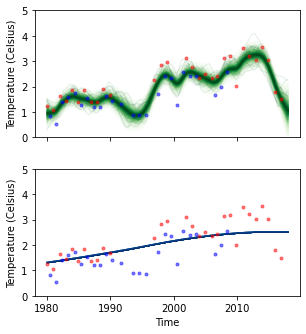

In [108]:
fig, ax = plt.subplots(2, 1, sharex="col", sharey="row", figsize=[4.75, 5.25])
fig.subplots_adjust(hspace=0.25, wspace=0.35)


# plot the samples from the gp posterior with samples and shading
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax[0], pred_samples_all["f_pred"], X_new, palette="Greens");
plot_gp_dist(ax[1], pred_samples["f_star"], X_new, palette="Blues");


# plot the data and the true latent function
# plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax[0].plot(X_db, y_db, 'or', ms=3, alpha=0.5, label="Observed data Khazendar");
ax[0].plot(X_mo, y_mo, 'ob', ms=3, alpha=0.5, label="Observed data Motyka");
ax[1].plot(X_db, y_db, 'or', ms=3, alpha=0.5, label="Observed data Khazendar");
ax[1].plot(X_mo, y_mo, 'ob', ms=3, alpha=0.5, label="Observed data Motyka");



# axis labels and title
ax[1].set_xlabel("Time")
ax[0].set_ylabel("Temperature (Celsius)")
ax[1].set_ylabel("Temperature (Celsius)")

ax[0].set_ylim(0, 5)
ax[1].set_ylim(0, 5)


mat32


mat52


exp


exp-quad


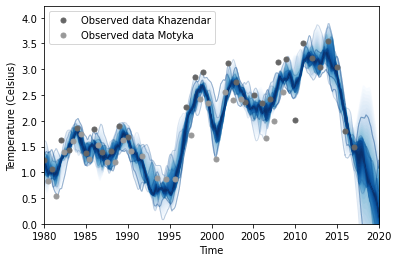

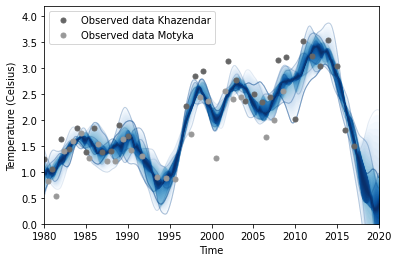

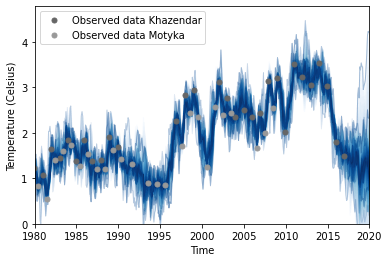

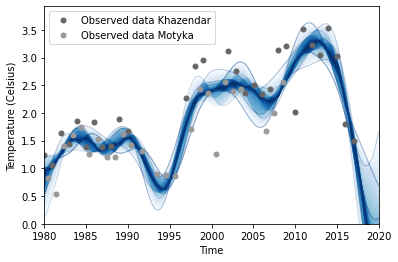

In [120]:
run create_disko_bay_timeseries.py

In [85]:
        theta_ocean = temperate - melting_point_temperature(depth, salinity)


In [95]:
NC?

In [92]:
nx = 3
ny = 4
nt = len(theta_ocean)
np.repeat(theta_ocean, nx*ny).reshape(nt, ny, nx).shape

(480, 4, 3)

In [100]:
time_interval_since_refdate

array([   15.5,    45.5,    75.5,   106. ,   136.5,   167. ,   197.5,
         228.5,   259. ,   289.5,   320. ,   350.5,   381.5,   411. ,
         440.5,   471. ,   501.5,   532. ,   562.5,   593.5,   624. ,
         654.5,   685. ,   715.5,   746.5,   776. ,   805.5,   836. ,
         866.5,   897. ,   927.5,   958.5,   989. ,  1019.5,  1050. ,
        1080.5,  1111.5,  1141. ,  1170.5,  1201. ,  1231.5,  1262. ,
        1292.5,  1323.5,  1354. ,  1384.5,  1415. ,  1445.5,  1476.5,
        1506.5,  1536.5,  1567. ,  1597.5,  1628. ,  1658.5,  1689.5,
        1720. ,  1750.5,  1781. ,  1811.5,  1842.5,  1872. ,  1901.5,
        1932. ,  1962.5,  1993. ,  2023.5,  2054.5,  2085. ,  2115.5,
        2146. ,  2176.5,  2207.5,  2237. ,  2266.5,  2297. ,  2327.5,
        2358. ,  2388.5,  2419.5,  2450. ,  2480.5,  2511. ,  2541.5,
        2572.5,  2602. ,  2631.5,  2662. ,  2692.5,  2723. ,  2753.5,
        2784.5,  2815. ,  2845.5,  2876. ,  2906.5,  2937.5,  2967.5,
        2997.5,  302

In [102]:
len(bnds_interval_since_refdate)

480

In [103]:
    start_date = datetime(1980, 1, 1)
    end_date = datetime(2020, 1, 1)
    end_date_yearly = datetime(2020, 1, 1)

    # create list with dates from start_date until end_date with
    # periodicity prule.
    bnds_datelist = list(rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date_yearly))
    bnds_datelist_yearly = list(rrule.rrule(rrule.YEARLY, dtstart=start_date, until=end_date_yearly))

    # calculate the days since refdate, including refdate, with time being the
    bnds_interval_since_refdate = cdftime_days.date2num(bnds_datelist)
    bnds_interval_since_refdate_yearly = cdftime_days.date2num(bnds_datelist_yearly)
    time_interval_since_refdate = bnds_interval_since_refdate[0:-1] + np.diff(bnds_interval_since_refdate) / 2


In [117]:
    start_date = datetime(1980, 1, 1)
    end_date = datetime(2020, 1, 1)
    end_date_yearly = datetime(2020, 1, 2)

    # create list with dates from start_date until end_date with
    # periodicity prule.
    bnds_datelist = list(rrule.rrule(rrule.MONTHLY, dtstart=start_date, until=end_date))
    bnds_datelist_yearly = list(rrule.rrule(rrule.YEARLY, dtstart=start_date, until=end_date_yearly))

    # calculate the days since refdate, including refdate, with time being the
    bnds_interval_since_refdate = cdftime_days.date2num(bnds_datelist)
    bnds_interval_since_refdate_yearly = cdftime_days.date2num(bnds_datelist_yearly)
    time_interval_since_refdate = bnds_interval_since_refdate[0:-1] + np.diff(bnds_interval_since_refdate) / 2

    time_dict = {
        "calendar": calendar,
        "units": units,
        "time": time_interval_since_refdate,
        "time_bnds": bnds_interval_since_refdate,
    }

    dpy = np.diff(bnds_interval_since_refdate_yearly)
    dpy = np.repeat(dpy, 12, axis=0)

    decimal_time = bnds_interval_since_refdate[0:-1] / dpy + 1980


In [112]:
pm.gp.cov.

480

In [116]:
len(bnds_interval_since_refdate[0:-1])

480